In [8]:
!git clone https://github.com/mlyulko145/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project.git

Cloning into 'AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 85 (delta 30), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 24.46 KiB | 3.49 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [9]:
%cd AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project

/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project


In [10]:
!ls

data  notebook	README.md  src	tests


In [11]:
%cd notebook

/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project/notebook


In [ ]:
!pip install pandas matplotlib pytest

In [12]:
import pandas as pd

prices_df = pd.read_csv("../data/prices.csv")
nec_df = pd.read_csv("../data/necessity_survey.csv")

print(prices_df.head())
print(nec_df.head())


    food      store  price  expiration_days
0   Milk   ShopRite   3.49                7
1   Milk  Walgreens   3.99                7
2   Eggs   ShopRite   4.29               14
3   Eggs  Walgreens   4.59               14
4  Bread   ShopRite   2.99                5
      food  necessity_score
0     Milk                5
1     Eggs                4
2    Bread                4
3     Rice                3
4  Chicken                5


In [13]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.quality_metric import QualityMetric
from src.food_item import FoodItem
from src.utils import average_price, accessibility_score

In [14]:
# Lookup for necessity scores
necessity_lookup = dict(
    zip(nec_df["food"], nec_df["necessity_score"])  # zip() to build lookup table
)

items = []  # list of FoodItem objects

for food in prices_df["food"].unique():
    # filter rows for this food
    food_rows = prices_df[prices_df["food"] == food]

    # average price for this food
    avg = average_price(list(food_rows["price"]))

    for _, row in food_rows.iterrows():
        price = float(row["price"])
        exp_days = int(row["expiration_days"])
        necessity = int(necessity_lookup.get(food, 1))

        price_score = accessibility_score(price, avg)
        necessity_score = necessity / 5.0
        expiration_score = exp_days / prices_df["expiration_days"].max()

        metric = QualityMetric(
            price_score,
            necessity_score,
            expiration_score
        )

        item = FoodItem(
            food,
            row["store"],
            price,
            exp_days,
            necessity,
            metric
        )

        items.append(item)

In [15]:
# List comprehension
top_items = sorted(items, reverse=True)[:5]  # uses operator overloading (__lt__)
top_strings = [str(item) for item in top_items]
print("\n".join(top_strings))

Rice @ ShopRite | $6.99, exp=365 days, necessity=3, score=0.880
Rice @ Walgreens | $7.49, exp=365 days, necessity=3, score=0.863
Milk @ ShopRite | $3.49, exp=7 days, necessity=5, score=0.804
Chicken @ ShopRite | $9.99, exp=3 days, necessity=5, score=0.802
Chicken @ Walgreens | $10.49, exp=3 days, necessity=5, score=0.790


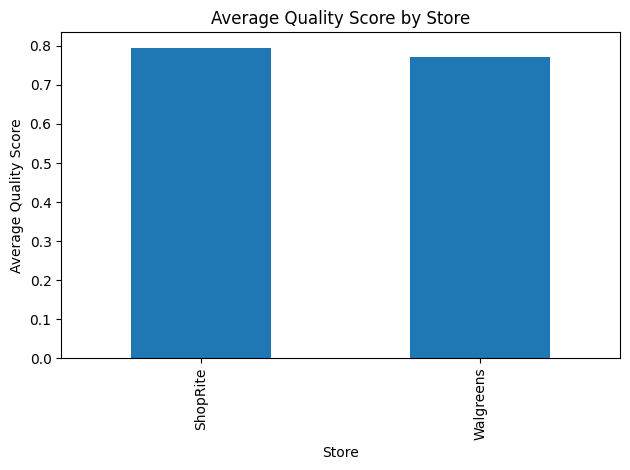

In [16]:
import matplotlib.pyplot as plt

# Build a DataFrame of overall scores for plotting
plot_df = pd.DataFrame({
    "food": [i.name for i in items],
    "store": [i.store for i in items],
    "score": [i.metric.overall_score() for i in items],
    "price": [i.price for i in items],
})

# Average score per store
store_avg = plot_df.groupby("store")["score"].mean().sort_values(ascending=False)

plt.figure()
store_avg.plot(kind="bar")
plt.title("Average Quality Score by Store")
plt.ylabel("Average Quality Score")
plt.xlabel("Store")
plt.tight_layout()
plt.show()


In [19]:
%cd ..

/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project


In [20]:
!ls


data  notebook	README.md  src	tests


In [21]:
!pytest


============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project
plugins: anyio-4.12.0, langsmith-0.4.56, typeguard-4.4.4
collected 2 items                                                              

tests/test_metrics.py ..                                                 [100%]

============================== 2 passed in 0.03s ===============================
